In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/starbucks-customer-data/transcript.csv
/kaggle/input/starbucks-customer-data/profile.csv
/kaggle/input/starbucks-customer-data/portfolio.csv


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly as py
import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode, iplot, plot

import warnings 
warnings.filterwarnings('ignore')
%matplotlib inline

In [3]:
portfolio = pd.read_csv('../input/starbucks-customer-data/portfolio.csv')
profile = pd.read_csv('../input/starbucks-customer-data/profile.csv')
transcript = pd.read_csv('../input/starbucks-customer-data/transcript.csv')

In [4]:
portfolio.info()
profile.info()
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  10 non-null     int64 
 1   reward      10 non-null     int64 
 2   channels    10 non-null     object
 3   difficulty  10 non-null     int64 
 4   duration    10 non-null     int64 
 5   offer_type  10 non-null     object
 6   id          10 non-null     object
dtypes: int64(4), object(3)
memory usage: 688.0+ bytes
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        17000 non-null  int64  
 1   gender            14825 non-null  object 
 2   age               17000 non-null  int64  
 3   id                17000 non-null  object 
 4   became_member_on  17000 non-null  int64  
 5   income            14825 non-null  float64


In [5]:
portfolio.isnull().sum()

Unnamed: 0    0
reward        0
channels      0
difficulty    0
duration      0
offer_type    0
id            0
dtype: int64

In [6]:
profile.isnull().sum()

Unnamed: 0             0
gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

In [7]:
transcript.isnull().sum()

Unnamed: 0    0
person        0
event         0
value         0
time          0
dtype: int64

In [8]:
profile.drop('Unnamed: 0', axis=1, inplace=True)
transcript.drop('Unnamed: 0', axis=1, inplace=True)
portfolio.drop('Unnamed: 0', axis=1, inplace=True)

In [9]:
profile['gender'].fillna("O", inplace=True)

In [10]:
profile[profile['age']==118]['gender'].value_counts()

O    2175
Name: gender, dtype: int64

In [11]:
profile.drop(profile.index[(profile['age'] < 119) & (profile['age'] > 100)], inplace = True)
profile.isnull().sum()

gender              0
age                 0
id                  0
became_member_on    0
income              0
dtype: int64

In [12]:
gender_profile = profile.gender.value_counts().reset_index()
gender_profile.columns = ['gender', 'count']
fig = px.pie(gender_profile, values='count', names='gender', title='Gender',
             color_discrete_sequence=['blue', 'light green'])
fig.show()

<AxesSubplot:xlabel='income'>

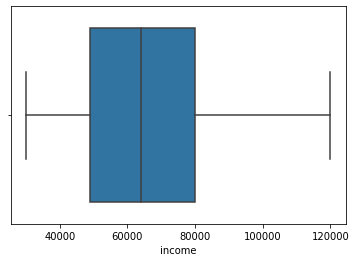

In [13]:
sns.boxplot(data=profile, x='income')

In [14]:
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'].astype(str), format='%Y%m%d')
profile['became_member_on'].head()

1    2017-07-15
3    2017-05-09
5    2018-04-26
8    2018-02-09
12   2017-11-11
Name: became_member_on, dtype: datetime64[ns]

In [15]:
profile['year'] = profile['became_member_on'].dt.year
profile['month'] = profile['became_member_on'].dt.month
profile['day']=profile['became_member_on'].dt.day_name()
profile['membership_days'] = (pd.to_datetime('today') - profile['became_member_on']).astype('timedelta64[D]').astype(int)

Text(0, 0.5, 'income')

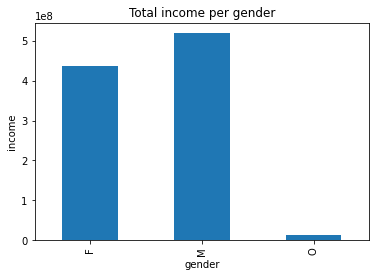

In [16]:
profile.groupby('gender').sum()['income'].plot(kind='bar')
plt.title('Total income per gender')
plt.ylabel('income')

In [17]:
profile['age_group'] = pd.cut(x=profile['age'], bins=[18, 20, 40, 60, 101],
                    labels=['Teenage(0-19)', 'Young(20-39)','Middle-age(40-59)',
                            'Old(60-100)'], include_lowest=True)
profile['age_group']

1        Middle-age(40-59)
3              Old(60-100)
5              Old(60-100)
8              Old(60-100)
12       Middle-age(40-59)
               ...        
16995    Middle-age(40-59)
16996          Old(60-100)
16997    Middle-age(40-59)
16998          Old(60-100)
16999          Old(60-100)
Name: age_group, Length: 14820, dtype: category
Categories (4, object): ['Teenage(0-19)' < 'Young(20-39)' < 'Middle-age(40-59)' < 'Old(60-100)']

In [18]:
from sklearn.preprocessing import LabelEncoder

profile = profile.copy(deep = True)
le_id = LabelEncoder()
profile['age_group'] = le_id.fit_transform(profile['age_group'])
profile.head(5)
profile

,gender,age,id,became_member_on,income,year,month,day,membership_days,age_group
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,2017,7,Saturday,1728,0
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,2017,5,Tuesday,1795,1
5,M,68,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0,2018,4,Thursday,1443,1
8,M,65,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0,2018,2,Friday,1519,1
12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,51000.0,2017,11,Saturday,1609,0
...,...,...,...,...,...,...,...,...,...,...
16995,F,45,6d5f3a774f3d4714ab0c092238f3a1d7,2018-06-04,54000.0,2018,6,Monday,1404,0
16996,M,61,2cb4f97358b841b9a9773a7aa05a9d77,2018-07-13,72000.0,2018,7,Friday,1365,1
16997,M,49,01d26f638c274aa0b965d24cefe3183f,2017-01-26,73000.0,2017,1,Thursday,1898,0
16998,F,83,9dc1421481194dcd9400aec7c9ae6366,2016-03-07,50000.0,2016,3,Monday,2223,1


In [19]:
transcript.rename(columns={'person':'id'}, inplace=True)

In [20]:
df = pd.merge(profile, transcript, on='id')
df = df.drop(['became_member_on'], axis=1)
df

,gender,age,id,income,year,month,day,membership_days,age_group,event,value,time
0,F,55,0610b486422d4921ae7d2bf64640c50b,112000.0,2017,7,Saturday,1728,0,transaction,{'amount': 21.51},18
1,F,55,0610b486422d4921ae7d2bf64640c50b,112000.0,2017,7,Saturday,1728,0,transaction,{'amount': 32.28},144
2,F,55,0610b486422d4921ae7d2bf64640c50b,112000.0,2017,7,Saturday,1728,0,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},408
3,F,55,0610b486422d4921ae7d2bf64640c50b,112000.0,2017,7,Saturday,1728,0,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},504
4,F,55,0610b486422d4921ae7d2bf64640c50b,112000.0,2017,7,Saturday,1728,0,transaction,{'amount': 23.22},528
...,...,...,...,...,...,...,...,...,...,...,...,...
272659,F,62,e4052622e5ba45a8b96b59aba68cf068,82000.0,2017,7,Saturday,1721,1,offer completed,{'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d...,480
272660,F,62,e4052622e5ba45a8b96b59aba68cf068,82000.0,2017,7,Saturday,1721,1,transaction,{'amount': 19.47},486
272661,F,62,e4052622e5ba45a8b96b59aba68cf068,82000.0,2017,7,Saturday,1721,1,offer viewed,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},546
272662,F,62,e4052622e5ba45a8b96b59aba68cf068,82000.0,2017,7,Saturday,1721,1,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},576


In [21]:
#map the offer_id from df with id in portfolio

#create dict such that offers['offer_id']= offerName_difficulty_duration
offers=dict()
for offer, i, diff, dur in portfolio[['offer_type', 'id', 'difficulty', 'duration']].values:
    offers[i]= f'{offer}_{diff}_{dur}'


def value_col(col):
    """
    extract offer_id from value column and mapped it to the offer name
    
    input- value column
    
    output-  mapped offer names
    """
    value_type= col.split(':')[0].replace("'", "").replace('{', "")
    
    if value_type == 'offer id':
        value= col.split(':')[1].replace("'", "").replace('}', "").strip()
        return offers[value]
    elif value_type == 'offer_id':
        value= col.split(':')[1].split(',')[0].replace("'", "").strip()
        return offers[value]
    else:
        return 'None'

In [22]:
#get offer names
df['offer']= df['value'].apply(value_col)

In [23]:
def value_col_id(col):
    """
    extract offer_id from value column
    
    input- value column
    
    output- offer_ids
    """
    value_type= col.split(':')[0].replace("'", "").replace('{', "")
    
    if value_type == 'offer id':
        value= col.split(':')[1].replace("'", "").replace('}', "").strip()
        return value
    elif value_type == 'offer_id':
        value= col.split(':')[1].split(',')[0].replace("'", "").strip()
        return value
    else:
        return 'None'

In [24]:
#get offer ids
df['offer_id']= df['value'].apply(value_col_id)

In [25]:
def value_col_trans(col):
    """
    get transaction amount from value column
    
    input- value column
    
    output- transaction amount
    """
    value_type= col.split(':')[0].replace("'", "").replace('{', "")
    
    if value_type == 'amount':
        value= col.split(':')[1].replace("'", "").replace('}', "").strip()
        return np.round(float(value), 2)
    else:
        return np.nan

In [26]:
#get transaction amount
df['amount']= df['value'].apply(value_col_trans)

In [27]:
df

,gender,age,id,income,year,month,day,membership_days,age_group,event,value,time,offer,offer_id,amount
0,F,55,0610b486422d4921ae7d2bf64640c50b,112000.0,2017,7,Saturday,1728,0,transaction,{'amount': 21.51},18,None,None,21.51
1,F,55,0610b486422d4921ae7d2bf64640c50b,112000.0,2017,7,Saturday,1728,0,transaction,{'amount': 32.28},144,None,None,32.28
2,F,55,0610b486422d4921ae7d2bf64640c50b,112000.0,2017,7,Saturday,1728,0,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},408,bogo_5_7,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
3,F,55,0610b486422d4921ae7d2bf64640c50b,112000.0,2017,7,Saturday,1728,0,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},504,informational_0_4,3f207df678b143eea3cee63160fa8bed,NaN
4,F,55,0610b486422d4921ae7d2bf64640c50b,112000.0,2017,7,Saturday,1728,0,transaction,{'amount': 23.22},528,None,None,23.22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
272659,F,62,e4052622e5ba45a8b96b59aba68cf068,82000.0,2017,7,Saturday,1721,1,offer completed,{'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d...,480,bogo_5_5,f19421c1d4aa40978ebb69ca19b0e20d,NaN
272660,F,62,e4052622e5ba45a8b96b59aba68cf068,82000.0,2017,7,Saturday,1721,1,transaction,{'amount': 19.47},486,None,None,19.47
272661,F,62,e4052622e5ba45a8b96b59aba68cf068,82000.0,2017,7,Saturday,1721,1,offer viewed,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},546,bogo_5_5,f19421c1d4aa40978ebb69ca19b0e20d,NaN
272662,F,62,e4052622e5ba45a8b96b59aba68cf068,82000.0,2017,7,Saturday,1721,1,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},576,informational_0_4,3f207df678b143eea3cee63160fa8bed,NaN


In [28]:
df['offer'] = df['offer'].str.replace('_', '')
df['offer'] = df['offer'].str.replace('\d+', '')
df

,gender,age,id,income,year,month,day,membership_days,age_group,event,value,time,offer,offer_id,amount
0,F,55,0610b486422d4921ae7d2bf64640c50b,112000.0,2017,7,Saturday,1728,0,transaction,{'amount': 21.51},18,None,None,21.51
1,F,55,0610b486422d4921ae7d2bf64640c50b,112000.0,2017,7,Saturday,1728,0,transaction,{'amount': 32.28},144,None,None,32.28
2,F,55,0610b486422d4921ae7d2bf64640c50b,112000.0,2017,7,Saturday,1728,0,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},408,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
3,F,55,0610b486422d4921ae7d2bf64640c50b,112000.0,2017,7,Saturday,1728,0,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},504,informational,3f207df678b143eea3cee63160fa8bed,NaN
4,F,55,0610b486422d4921ae7d2bf64640c50b,112000.0,2017,7,Saturday,1728,0,transaction,{'amount': 23.22},528,None,None,23.22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
272659,F,62,e4052622e5ba45a8b96b59aba68cf068,82000.0,2017,7,Saturday,1721,1,offer completed,{'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d...,480,bogo,f19421c1d4aa40978ebb69ca19b0e20d,NaN
272660,F,62,e4052622e5ba45a8b96b59aba68cf068,82000.0,2017,7,Saturday,1721,1,transaction,{'amount': 19.47},486,None,None,19.47
272661,F,62,e4052622e5ba45a8b96b59aba68cf068,82000.0,2017,7,Saturday,1721,1,offer viewed,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},546,bogo,f19421c1d4aa40978ebb69ca19b0e20d,NaN
272662,F,62,e4052622e5ba45a8b96b59aba68cf068,82000.0,2017,7,Saturday,1721,1,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},576,informational,3f207df678b143eea3cee63160fa8bed,NaN


In [29]:
from sklearn.preprocessing import LabelEncoder

df = df.copy(deep = True)
le_offer = LabelEncoder()
df['offer'] = le_offer.fit_transform(df['offer'])
df.head(5)
df

,gender,age,id,income,year,month,day,membership_days,age_group,event,value,time,offer,offer_id,amount
0,F,55,0610b486422d4921ae7d2bf64640c50b,112000.0,2017,7,Saturday,1728,0,transaction,{'amount': 21.51},18,0,None,21.51
1,F,55,0610b486422d4921ae7d2bf64640c50b,112000.0,2017,7,Saturday,1728,0,transaction,{'amount': 32.28},144,0,None,32.28
2,F,55,0610b486422d4921ae7d2bf64640c50b,112000.0,2017,7,Saturday,1728,0,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},408,1,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
3,F,55,0610b486422d4921ae7d2bf64640c50b,112000.0,2017,7,Saturday,1728,0,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},504,3,3f207df678b143eea3cee63160fa8bed,NaN
4,F,55,0610b486422d4921ae7d2bf64640c50b,112000.0,2017,7,Saturday,1728,0,transaction,{'amount': 23.22},528,0,None,23.22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
272659,F,62,e4052622e5ba45a8b96b59aba68cf068,82000.0,2017,7,Saturday,1721,1,offer completed,{'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d...,480,1,f19421c1d4aa40978ebb69ca19b0e20d,NaN
272660,F,62,e4052622e5ba45a8b96b59aba68cf068,82000.0,2017,7,Saturday,1721,1,transaction,{'amount': 19.47},486,0,None,19.47
272661,F,62,e4052622e5ba45a8b96b59aba68cf068,82000.0,2017,7,Saturday,1721,1,offer viewed,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},546,1,f19421c1d4aa40978ebb69ca19b0e20d,NaN
272662,F,62,e4052622e5ba45a8b96b59aba68cf068,82000.0,2017,7,Saturday,1721,1,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},576,3,3f207df678b143eea3cee63160fa8bed,NaN


In [30]:
df.income.astype(int)

0         112000
1         112000
2         112000
3         112000
4         112000
           ...  
272659     82000
272660     82000
272661     82000
272662     82000
272663     82000
Name: income, Length: 272664, dtype: int64